In [1]:
import numpy as np
import datetime
import statsmodels.api as sm
from statsmodels.sandbox.tools.tools_pca import pca
from scipy import stats
from statsmodels.regression.rolling import RollingOLS
import random
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  
import os.path  
import sys  
import backtrader as bt
from backtrader import Indicator
import os
import math
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy

import pandas as pd

from sklearn.decomposition import PCA
from matplotlib.pyplot import figure


# Backtrader: Strategy Indicators

In [2]:
class Arbitrage:
    def __init__(self, window, pca_window, n_pc, req_k):
        self.window = window
        self.pca_window = pca_window
        self.n_pc = n_pc
        self.req_k = req_k
        self.all_rets = pd.DataFrame()
        self.all_prices = pd.DataFrame()
        
    def run_pca(self, rets):
        std = rets.std(0)
        std_rets = (rets - rets.mean(0)) / std
        cov = std_rets.cov()
        pca = PCA(n_components = self.n_pc, random_state=1)
        pca.fit(std_rets)
        norm_wgt = pd.DataFrame(pca.components_, columns=rets.columns,index=['PC{}'.format(i + 1) for i in range(self.n_pc)]).T
        norm_wgt = norm_wgt.div(std, axis=0)
        norm_wgt = norm_wgt / norm_wgt.sum()
        pc_rets = pd.DataFrame(np.dot(rets, norm_wgt), index=rets.index, columns=['PC{}'.format(i+1) for i in range(self.n_pc)])
        return norm_wgt, pc_rets, pca.explained_variance_ratio_
    
    def run_ols(self, rets, pc_rets):
        tickers = rets.columns
        pc_rets= sm.add_constant(pc_rets)
        result = pd.DataFrame(index=tickers, columns = pc_rets.columns)
        for t in tickers:
            res = sm.OLS(rets[t], pc_rets).fit()
            result.loc[t] = res.params
        return result
    
    def cal_score(self, rets, pc_rets , ols_result):
        tickers = rets.columns
        
        m = pd.Series(index=tickers, dtype='float')
        sigma_eq = pd.Series(index=tickers, dtype='float')
        k = pd.Series(index=tickers, dtype='float')

        for t in tickers:
            dX = rets[t] - np.dot(sm.add_constant(pc_rets), ols_result.loc[t])
            X = dX.astype('float').cumsum()
            b = X.autocorr()
            temp = (X-X.shift(1)* b)[1:]
            a = temp.mean()
            resid =temp - a
            m.loc[t] = a/(1-b)
            sigma_eq.loc[t] = math.sqrt(resid.var()/(1-b*b))
            k.loc[t] = -math.log(b) * 252
            
        m = m.dropna()
        sigma_eq = sigma_eq.loc[m.index]
        m = m - m.mean()
        s_score = -m / sigma_eq
        s_score = s_score.loc[k>self.req_k]
        return s_score.index, s_score
        
    def fit(self,rets):
        norm_wgt, pc_rets, explained_variance_ratio_ = self.run_pca(rets.tail(self.pca_window).dropna(1))
        ols_result = self.run_ols(rets.tail(self.window).dropna(1), pc_rets.tail(self.window))
        tickers, s_score = self.cal_score(rets.tail(self.window).dropna(1), pc_rets.tail(self.window), ols_result)
        self.all_rets = rets
        return {'tickers': tickers, 's_score': s_score, 'norm_wgt': norm_wgt, 'ols_result': ols_result, 'explained_var': explained_variance_ratio_}
    

    def add_prices(self, new_prices_df):
        self.all_prices = self.all_prices.append(new_prices_df)
        if self.all_prices.shape[0] >=2:
            self.all_rets = self.all_rets.append(self.all_prices.iloc[-1, :] / self.all_prices.iloc[-2, :] -1 )
        
    def start_trade(self):
        return self.all_rets.shape[0] >= max(self.window, self.pca_window)
    
    def get(self):
        return self.fit(self.all_rets)
        

# Backtrader

In [3]:
class FMRV(bt.Strategy):
    params = (
        ('window', 60),('pca_window', 252), ('n_pc', 12), ('req_k', 252/20),
        ('s_bo', 1.25), ('s_so', 1.25), ('s_cs', 0.75), ('s_cl', 0.5),
        ('max_n_pos', 50), ('leverage', 4),
    )

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        
        # Data Feeds
        self.stocks_d = [self.datas[i] for i in range(len(self.datas))]
        
        # Tickers
        self.tickers = [d._name for d in self.stocks_d]
        
        # key is ticker
        self.hedged_port_size = dict()
        self.long =  dict()
        self.short =  dict()
        self.hv_pos =  dict()
        self.n_pos = 0
        self.data_by_ticker = dict()
        
        for d in self.stocks_d:
            self.long[d._name] = 0
            self.short[d._name] = 0
            self.hv_pos[d._name] = 0
            self.hedged_port_size[d._name] = pd.DataFrame()
            self.data_by_ticker[d._name] = d
            
        # record
        self.cash_l = list()
        self.pv = list()
        self.n_pos_l = list()
        self.leverage_l = list()
        self.exposure_l = list()
        self.concentration_l = list()
        self.explained_var = list()
        
        # internal record of position
        self.cur_position = pd.Series(0, index=self.tickers)
        
        # order 
        self.o = defaultdict(list)
        
        # Arbitrage
        self.algo = Arbitrage(window=self.p.window, pca_window=self.p.pca_window, n_pc=self.p.n_pc, req_k=self.p.req_k)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
            raise Exception('Margin')
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')

        self.o[order.data].remove(order)
        
    def longtrade(self, t, algo_res):
        self.hv_pos[t] = 1
        self.long[t] = 1
        self.n_pos = self.n_pos+1
            
        pv = self.broker.get_value() 
        inv_val = pv / self.p.max_n_pos * self.p.leverage
        
            
        long_value = pd.Series([1], index=[t])
        betas = algo_res['ols_result'].iloc[:, 1:].loc[t]
        hedge_values = -pd.Series(np.dot(algo_res['norm_wgt'], betas), index=algo_res['norm_wgt'].index)

        multiplier = inv_val / (np.abs(hedge_values.add(long_value, fill_value=0)).sum())
        
        long_value = multiplier * long_value
        trade_values = hedge_values * multiplier
        trade_values = trade_values.add(long_value, fill_value=0)
        
        trade_size = np.round(trade_values.div(self.algo.all_prices.iloc[-1]).dropna().astype('float'))
         
        self.hedged_port_size[t] = trade_size.copy()
        
        return trade_size
        
        
    def shorttrade(self, t, algo_res):
        self.hv_pos[t] = 1
        self.short[t] = 1
        self.n_pos = self.n_pos+1
                    
        pv = self.broker.get_value() 
        
        inv_val = pv / self.p.max_n_pos * self.p.leverage
        
        short_value = -pd.Series([1], index=[t])
        betas = algo_res['ols_result'].iloc[:, 1:].loc[t]
        hedge_values = pd.Series(np.dot(algo_res['norm_wgt'], betas), index=algo_res['norm_wgt'].index)

        multiplier = inv_val / (np.abs(hedge_values.add(short_value, fill_value=0)).sum())
        
        short_value = multiplier * short_value
        trade_values = hedge_values * multiplier
        trade_values = trade_values.add(short_value, fill_value=0)
        
        trade_size = np.round(trade_values.div(self.algo.all_prices.iloc[-1]).dropna().astype('float'))
        
        self.hedged_port_size[t] = trade_size.copy()
        
        return trade_size
    
    def unwound(self, t):
        self.hv_pos[t] = 0
        self.long[t] = 0
        self.short[t] = 0
        self.n_pos = self.n_pos-1
        trade_size = -1 * self.hedged_port_size[t]
        self.hedged_port_size[t] = None
        return trade_size
    
    def log_info(self, algo_res):
        pos_values = self.cur_position.multiply(self.algo.all_prices.iloc[-1,:], fill_value=0)
        abs_pos_vals = np.abs(pos_values)
        pv = self.broker.get_value()
        leverage = abs_pos_vals.sum()/ pv * 100
        
        self.pv.append(self.broker.get_value())
        self.cash_l.append(self.broker.get_cash())
        self.n_pos_l.append(self.n_pos)
        self.leverage_l.append(leverage)
        self.concentration_l.append((abs_pos_vals / abs_pos_vals.sum() * 100).values)
        explained_var = np.sum(algo_res['explained_var'])
        self.explained_var.append(explained_var)
        
        self.log(f'PV:{self.broker.get_value()}')
        self.log('Gross Leverage: {:.1f}%'.format(leverage))
        self.log('Dollar Exposure: {:.1f}%'.format(pos_values.sum() / pv * 100))
        self.log(f'Pos: {self.n_pos}')
        self.log(f'Explained Var: {explained_var}')
        self.log('----------------------------------------------------------------')
        
    def next(self):
        # Fedd price to algo class
        new_prices = list()
        for d in self.stocks_d:
            new_prices.append(d[0])
        new_prices = pd.DataFrame([new_prices], columns=self.tickers)
        self.algo.add_prices(new_prices)
        
        # Data warm-up period
        if not self.algo.start_trade():
            return
        
        # Get S scores
        algo_res = self.algo.get()
        self.log_info(algo_res)
        
        # Initialize trade_size vector
        trade_size = pd.Series(0, index=self.tickers)
        
        for t in algo_res['tickers']:
            s = algo_res['s_score'][t] 
            if (not self.hv_pos[t]) and (self.n_pos < self.p.max_n_pos):
                
                if s < -self.p.s_bo:
                    
                    trade_size = trade_size.add(self.longtrade(t, algo_res), fill_value=0)
                    
                elif s > self.p.s_so:
                    
                    trade_size = trade_size.add(self.shorttrade(t, algo_res), fill_value=0)

            elif self.hv_pos[t]:
                
                if (self.long[t]) and (s > -self.p.s_cl):
                    
                    trade_size = trade_size.add(self.unwound(t), fill_value=0)
                    
                elif (self.short[t]) and (s<self.p.s_cs):
                    
                    trade_size = trade_size.add(self.unwound(t), fill_value=0)

        self.cur_position = self.cur_position.add(trade_size, fill_value=0)   

        for t in trade_size.index:
            size = trade_size.loc[t]
            if size > 0:
                d = self.data_by_ticker[t]
                self.o[d].append(self.buy(data=d, size=size))
            elif size < 0:
                d = self.data_by_ticker[t]
                self.o[d].append(self.sell(data=self.data_by_ticker[t], size=size))
        
    def stop(self):
        pv = pd.Series(self.pv)
        rets = pv.pct_change()
        sharpe = rets.mean() / rets.std() * math.sqrt(252)
        self.log(f'req_k:{self.p.req_k}, s_bo: {self.p.s_bo}, s_so: {self.p.s_so}, s_cs: {self.p.s_cs}, s_cl: {self.p.s_cl}')
        self.log(f'PV: {self.broker.getvalue()},Sharpe:{sharpe}')

            
def run_all(path, start_date, init_cash):
    
    cerebro = bt.Cerebro()
    cerebro.addstrategy(FMRV, req_k=252/20, s_bo=1, s_so=1.25,  s_cs=0.75, s_cl=0.5, n_pc=15, max_n_pos=200, leverage=12, pca_window=252)

    for d in os.listdir(path):
        if '.csv' in d:
            data = bt.feeds.GenericCSVData(
                dataname=f'{path}/{d}',
                name=d.split('.')[0],
                fromdate=start_date,
                todate=datetime.datetime(2021, 6, 1),
                reverse=False,
                dtformat='%Y-%m-%d',
                open=5,
                datetime=0,
                close=2,
                volume=6,)
            cerebro.adddata(data)
    


    # Set the commission
    cerebro.broker.setcommission(commission=0.0001, leverage=40)
    cerebro.broker.set_shortcash(True)
    cerebro.broker.setcash(init_cash)

    # Run over everything
    results = cerebro.run(maxcpus=1)
    
    strat = results[0]
    return cerebro, results



In [4]:
cash = 10000000
cerebro, results = run_all(path = '../data/backtrader_csv/sp500nasdaq',
                                init_cash=cash,
                                start_date=datetime.datetime(2013, 1, 1))

2014-01-02, PV:10000000.0
2014-01-02, Gross Leverage: 0.0%
2014-01-02, Dollar Exposure: 0.0%
2014-01-02, Pos: 0
2014-01-02, Explained Var: 0.5014460290736588
2014-01-02, ----------------------------------------------------------------
2014-01-03, PV:10013933.972550131
2014-01-03, Gross Leverage: 189.9%
2014-01-03, Dollar Exposure: 10.1%
2014-01-03, Pos: 121
2014-01-03, Explained Var: 0.5020063986364968
2014-01-03, ----------------------------------------------------------------
2014-01-06, PV:9991013.659832856
2014-01-06, Gross Leverage: 230.4%
2014-01-06, Dollar Exposure: 13.4%
2014-01-06, Pos: 153
2014-01-06, Explained Var: 0.502002257051292
2014-01-06, ----------------------------------------------------------------
2014-01-07, PV:10003349.95751849
2014-01-07, Gross Leverage: 241.1%
2014-01-07, Dollar Exposure: 15.5%
2014-01-07, Pos: 158
2014-01-07, Explained Var: 0.5021791454883848
2014-01-07, ----------------------------------------------------------------
2014-01-08, PV:9976239.4

2014-02-21, PV:9865749.385812903
2014-02-21, Gross Leverage: 279.0%
2014-02-21, Dollar Exposure: -11.9%
2014-02-21, Pos: 182
2014-02-21, Explained Var: 0.5201703935212222
2014-02-21, ----------------------------------------------------------------
2014-02-24, PV:9847512.105875561
2014-02-24, Gross Leverage: 271.4%
2014-02-24, Dollar Exposure: -6.7%
2014-02-24, Pos: 178
2014-02-24, Explained Var: 0.5194208682138285
2014-02-24, ----------------------------------------------------------------
2014-02-25, PV:9831538.994596545
2014-02-25, Gross Leverage: 277.0%
2014-02-25, Dollar Exposure: -7.6%
2014-02-25, Pos: 182
2014-02-25, Explained Var: 0.5157881885455038
2014-02-25, ----------------------------------------------------------------
2014-02-26, PV:9849686.872635307
2014-02-26, Gross Leverage: 281.0%
2014-02-26, Dollar Exposure: -9.3%
2014-02-26, Pos: 186
2014-02-26, Explained Var: 0.5155549923358849
2014-02-26, ----------------------------------------------------------------
2014-02-27,

2014-04-10, PV:10026958.635813743
2014-04-10, Gross Leverage: 270.4%
2014-04-10, Dollar Exposure: -7.8%
2014-04-10, Pos: 187
2014-04-10, Explained Var: 0.5285040896169898
2014-04-10, ----------------------------------------------------------------
2014-04-11, PV:10051922.914278867
2014-04-11, Gross Leverage: 264.0%
2014-04-11, Dollar Exposure: -6.4%
2014-04-11, Pos: 190
2014-04-11, Explained Var: 0.5297025070748494
2014-04-11, ----------------------------------------------------------------
2014-04-14, PV:10050361.884460902
2014-04-14, Gross Leverage: 248.9%
2014-04-14, Dollar Exposure: -0.3%
2014-04-14, Pos: 177
2014-04-14, Explained Var: 0.5225530047371852
2014-04-14, ----------------------------------------------------------------
2014-04-15, PV:10035881.34183135
2014-04-15, Gross Leverage: 232.5%
2014-04-15, Dollar Exposure: 1.6%
2014-04-15, Pos: 164
2014-04-15, Explained Var: 0.5209541633933542
2014-04-15, ----------------------------------------------------------------
2014-04-16

2014-05-30, PV:10243676.716444103
2014-05-30, Gross Leverage: 258.9%
2014-05-30, Dollar Exposure: -2.6%
2014-05-30, Pos: 189
2014-05-30, Explained Var: 0.5188369435052387
2014-05-30, ----------------------------------------------------------------
2014-06-02, PV:10240482.903466837
2014-06-02, Gross Leverage: 264.5%
2014-06-02, Dollar Exposure: -0.7%
2014-06-02, Pos: 189
2014-06-02, Explained Var: 0.5171551092546286
2014-06-02, ----------------------------------------------------------------
2014-06-03, PV:10241546.731636807
2014-06-03, Gross Leverage: 264.1%
2014-06-03, Dollar Exposure: -1.9%
2014-06-03, Pos: 189
2014-06-03, Explained Var: 0.5173637917373038
2014-06-03, ----------------------------------------------------------------
2014-06-04, PV:10254877.530395959
2014-06-04, Gross Leverage: 233.0%
2014-06-04, Dollar Exposure: 1.9%
2014-06-04, Pos: 168
2014-06-04, Explained Var: 0.5171463254295472
2014-06-04, ----------------------------------------------------------------
2014-06-0

2014-07-18, PV:10337501.150889076
2014-07-18, Gross Leverage: 273.0%
2014-07-18, Dollar Exposure: 14.4%
2014-07-18, Pos: 200
2014-07-18, Explained Var: 0.4979861643141007
2014-07-18, ----------------------------------------------------------------
2014-07-21, PV:10316573.562363837
2014-07-21, Gross Leverage: 273.8%
2014-07-21, Dollar Exposure: 13.6%
2014-07-21, Pos: 198
2014-07-21, Explained Var: 0.49846366061169944
2014-07-21, ----------------------------------------------------------------
2014-07-22, PV:10293235.180329345
2014-07-22, Gross Leverage: 287.7%
2014-07-22, Dollar Exposure: 9.5%
2014-07-22, Pos: 199
2014-07-22, Explained Var: 0.49822935530700124
2014-07-22, ----------------------------------------------------------------
2014-07-23, PV:10333969.263789255
2014-07-23, Gross Leverage: 289.1%
2014-07-23, Dollar Exposure: 12.2%
2014-07-23, Pos: 199
2014-07-23, Explained Var: 0.4986128809306845
2014-07-23, ----------------------------------------------------------------
2014-07

2014-09-05, PV:10400952.827949239
2014-09-05, Gross Leverage: 278.2%
2014-09-05, Dollar Exposure: -15.4%
2014-09-05, Pos: 191
2014-09-05, Explained Var: 0.4989527588706308
2014-09-05, ----------------------------------------------------------------
2014-09-08, PV:10410305.713472707
2014-09-08, Gross Leverage: 294.2%
2014-09-08, Dollar Exposure: -15.9%
2014-09-08, Pos: 194
2014-09-08, Explained Var: 0.4992502847757547
2014-09-08, ----------------------------------------------------------------
2014-09-09, PV:10441129.48833236
2014-09-09, Gross Leverage: 291.9%
2014-09-09, Dollar Exposure: -13.8%
2014-09-09, Pos: 190
2014-09-09, Explained Var: 0.49879165315520074
2014-09-09, ----------------------------------------------------------------
2014-09-10, PV:10445655.448676849
2014-09-10, Gross Leverage: 293.9%
2014-09-10, Dollar Exposure: -11.4%
2014-09-10, Pos: 192
2014-09-10, Explained Var: 0.49823704236879346
2014-09-10, ----------------------------------------------------------------
201

2014-10-23, PV:10450825.310831277
2014-10-23, Gross Leverage: 303.5%
2014-10-23, Dollar Exposure: 1.3%
2014-10-23, Pos: 197
2014-10-23, Explained Var: 0.5223176185368197
2014-10-23, ----------------------------------------------------------------
2014-10-24, PV:10473188.986378705
2014-10-24, Gross Leverage: 315.0%
2014-10-24, Dollar Exposure: 1.8%
2014-10-24, Pos: 200
2014-10-24, Explained Var: 0.5235513786905095
2014-10-24, ----------------------------------------------------------------
2014-10-27, PV:10415217.644132487
2014-10-27, Gross Leverage: 313.9%
2014-10-27, Dollar Exposure: -3.2%
2014-10-27, Pos: 199
2014-10-27, Explained Var: 0.5246314706552463
2014-10-27, ----------------------------------------------------------------
2014-10-28, PV:10444329.548459003
2014-10-28, Gross Leverage: 308.5%
2014-10-28, Dollar Exposure: -4.3%
2014-10-28, Pos: 199
2014-10-28, Explained Var: 0.5262274882761035
2014-10-28, ----------------------------------------------------------------
2014-10-29

2014-12-11, PV:10522104.999521758
2014-12-11, Gross Leverage: 322.6%
2014-12-11, Dollar Exposure: -3.4%
2014-12-11, Pos: 200
2014-12-11, Explained Var: 0.5300518587748785
2014-12-11, ----------------------------------------------------------------
2014-12-12, PV:10543825.1197645
2014-12-12, Gross Leverage: 306.2%
2014-12-12, Dollar Exposure: -2.4%
2014-12-12, Pos: 197
2014-12-12, Explained Var: 0.5318672384496728
2014-12-12, ----------------------------------------------------------------
2014-12-15, PV:10561395.488508081
2014-12-15, Gross Leverage: 299.5%
2014-12-15, Dollar Exposure: -4.0%
2014-12-15, Pos: 194
2014-12-15, Explained Var: 0.5325504104426059
2014-12-15, ----------------------------------------------------------------
2014-12-16, PV:10589537.828453997
2014-12-16, Gross Leverage: 291.0%
2014-12-16, Dollar Exposure: -4.4%
2014-12-16, Pos: 190
2014-12-16, Explained Var: 0.532986159612576
2014-12-16, ----------------------------------------------------------------
2014-12-17,

2015-02-02, PV:10670015.962864084
2015-02-02, Gross Leverage: 304.4%
2015-02-02, Dollar Exposure: -6.0%
2015-02-02, Pos: 200
2015-02-02, Explained Var: 0.5517722931651567
2015-02-02, ----------------------------------------------------------------
2015-02-03, PV:10680548.057135021
2015-02-03, Gross Leverage: 309.0%
2015-02-03, Dollar Exposure: -3.8%
2015-02-03, Pos: 198
2015-02-03, Explained Var: 0.5468775344175184
2015-02-03, ----------------------------------------------------------------
2015-02-04, PV:10638893.355581535
2015-02-04, Gross Leverage: 302.4%
2015-02-04, Dollar Exposure: 0.9%
2015-02-04, Pos: 196
2015-02-04, Explained Var: 0.5460407781621911
2015-02-04, ----------------------------------------------------------------
2015-02-05, PV:10673058.604849992
2015-02-05, Gross Leverage: 308.3%
2015-02-05, Dollar Exposure: 2.3%
2015-02-05, Pos: 199
2015-02-05, Explained Var: 0.5463010349018631
2015-02-05, ----------------------------------------------------------------
2015-02-06

2015-03-23, PV:10891506.911998276
2015-03-23, Gross Leverage: 318.0%
2015-03-23, Dollar Exposure: -7.5%
2015-03-23, Pos: 198
2015-03-23, Explained Var: 0.5569806886154115
2015-03-23, ----------------------------------------------------------------
2015-03-24, PV:10906514.58143849
2015-03-24, Gross Leverage: 307.9%
2015-03-24, Dollar Exposure: -8.2%
2015-03-24, Pos: 198
2015-03-24, Explained Var: 0.5569778093475114
2015-03-24, ----------------------------------------------------------------
2015-03-25, PV:10960055.35207406
2015-03-25, Gross Leverage: 286.9%
2015-03-25, Dollar Exposure: -8.6%
2015-03-25, Pos: 189
2015-03-25, Explained Var: 0.5603291432325513
2015-03-25, ----------------------------------------------------------------
2015-03-26, PV:10989798.19499387
2015-03-26, Gross Leverage: 269.5%
2015-03-26, Dollar Exposure: -6.4%
2015-03-26, Pos: 177
2015-03-26, Explained Var: 0.5597117133290761
2015-03-26, ----------------------------------------------------------------
2015-03-27,

2015-05-11, PV:11166838.464803994
2015-05-11, Gross Leverage: 273.9%
2015-05-11, Dollar Exposure: -1.8%
2015-05-11, Pos: 197
2015-05-11, Explained Var: 0.552342050162465
2015-05-11, ----------------------------------------------------------------
2015-05-12, PV:11157946.329027448
2015-05-12, Gross Leverage: 277.4%
2015-05-12, Dollar Exposure: -2.4%
2015-05-12, Pos: 197
2015-05-12, Explained Var: 0.5505872242270741
2015-05-12, ----------------------------------------------------------------
2015-05-13, PV:11188178.276902962
2015-05-13, Gross Leverage: 271.6%
2015-05-13, Dollar Exposure: -2.7%
2015-05-13, Pos: 199
2015-05-13, Explained Var: 0.5500840921563951
2015-05-13, ----------------------------------------------------------------
2015-05-14, PV:11194653.513124853
2015-05-14, Gross Leverage: 274.0%
2015-05-14, Dollar Exposure: -3.0%
2015-05-14, Pos: 197
2015-05-14, Explained Var: 0.5508527405692196
2015-05-14, ----------------------------------------------------------------
2015-05-1

2015-06-29, PV:11207809.38993227
2015-06-29, Gross Leverage: 277.9%
2015-06-29, Dollar Exposure: -2.8%
2015-06-29, Pos: 199
2015-06-29, Explained Var: 0.5589157418386872
2015-06-29, ----------------------------------------------------------------
2015-06-30, PV:11204456.072485691
2015-06-30, Gross Leverage: 271.6%
2015-06-30, Dollar Exposure: -5.9%
2015-06-30, Pos: 188
2015-06-30, Explained Var: 0.5589464968439042
2015-06-30, ----------------------------------------------------------------
2015-07-01, PV:11203878.710661568
2015-07-01, Gross Leverage: 272.3%
2015-07-01, Dollar Exposure: -4.9%
2015-07-01, Pos: 192
2015-07-01, Explained Var: 0.5588331689566096
2015-07-01, ----------------------------------------------------------------
2015-07-02, PV:11194740.437416742
2015-07-02, Gross Leverage: 288.9%
2015-07-02, Dollar Exposure: -5.7%
2015-07-02, Pos: 200
2015-07-02, Explained Var: 0.5587877727785729
2015-07-02, ----------------------------------------------------------------
2015-07-0

2015-08-17, PV:11021958.739439739
2015-08-17, Gross Leverage: 291.0%
2015-08-17, Dollar Exposure: -10.7%
2015-08-17, Pos: 197
2015-08-17, Explained Var: 0.5564770687078858
2015-08-17, ----------------------------------------------------------------
2015-08-18, PV:11005805.610797822
2015-08-18, Gross Leverage: 291.0%
2015-08-18, Dollar Exposure: -12.9%
2015-08-18, Pos: 193
2015-08-18, Explained Var: 0.5549500266265146
2015-08-18, ----------------------------------------------------------------
2015-08-19, PV:11005173.15687323
2015-08-19, Gross Leverage: 283.7%
2015-08-19, Dollar Exposure: -14.3%
2015-08-19, Pos: 193
2015-08-19, Explained Var: 0.5552610289026674
2015-08-19, ----------------------------------------------------------------
2015-08-20, PV:11046832.9482576
2015-08-20, Gross Leverage: 285.7%
2015-08-20, Dollar Exposure: -13.1%
2015-08-20, Pos: 199
2015-08-20, Explained Var: 0.5596405792664504
2015-08-20, ----------------------------------------------------------------
2015-08

2015-10-05, PV:11154347.92137132
2015-10-05, Gross Leverage: 298.4%
2015-10-05, Dollar Exposure: -5.2%
2015-10-05, Pos: 193
2015-10-05, Explained Var: 0.6108816946310569
2015-10-05, ----------------------------------------------------------------
2015-10-06, PV:11114609.356121091
2015-10-06, Gross Leverage: 291.1%
2015-10-06, Dollar Exposure: -6.0%
2015-10-06, Pos: 192
2015-10-06, Explained Var: 0.6116671543988843
2015-10-06, ----------------------------------------------------------------
2015-10-07, PV:11210151.917552017
2015-10-07, Gross Leverage: 298.5%
2015-10-07, Dollar Exposure: -6.4%
2015-10-07, Pos: 199
2015-10-07, Explained Var: 0.6095512691700006
2015-10-07, ----------------------------------------------------------------
2015-10-08, PV:11166741.498831818
2015-10-08, Gross Leverage: 294.3%
2015-10-08, Dollar Exposure: -9.8%
2015-10-08, Pos: 191
2015-10-08, Explained Var: 0.6083819902379519
2015-10-08, ----------------------------------------------------------------
2015-10-0

2015-11-20, PV:11221391.014301721
2015-11-20, Gross Leverage: 320.8%
2015-11-20, Dollar Exposure: -3.7%
2015-11-20, Pos: 200
2015-11-20, Explained Var: 0.599893310482693
2015-11-20, ----------------------------------------------------------------
2015-11-23, PV:11218369.955397584
2015-11-23, Gross Leverage: 325.8%
2015-11-23, Dollar Exposure: -4.7%
2015-11-23, Pos: 200
2015-11-23, Explained Var: 0.5997020450284756
2015-11-23, ----------------------------------------------------------------
2015-11-24, PV:11215807.954163201
2015-11-24, Gross Leverage: 329.4%
2015-11-24, Dollar Exposure: -9.1%
2015-11-24, Pos: 200
2015-11-24, Explained Var: 0.5993600870700777
2015-11-24, ----------------------------------------------------------------
2015-11-25, PV:11201715.916321307
2015-11-25, Gross Leverage: 330.6%
2015-11-25, Dollar Exposure: -9.8%
2015-11-25, Pos: 196
2015-11-25, Explained Var: 0.5994693134460398
2015-11-25, ----------------------------------------------------------------
2015-11-2

2016-01-12, PV:11374480.332473125
2016-01-12, Gross Leverage: 323.4%
2016-01-12, Dollar Exposure: -3.0%
2016-01-12, Pos: 191
2016-01-12, Explained Var: 0.5994640256433561
2016-01-12, ----------------------------------------------------------------
2016-01-13, PV:11399786.166496053
2016-01-13, Gross Leverage: 309.5%
2016-01-13, Dollar Exposure: -7.8%
2016-01-13, Pos: 192
2016-01-13, Explained Var: 0.6035239092335531
2016-01-13, ----------------------------------------------------------------
2016-01-14, PV:11412859.103030894
2016-01-14, Gross Leverage: 289.3%
2016-01-14, Dollar Exposure: -8.8%
2016-01-14, Pos: 172
2016-01-14, Explained Var: 0.6041301924388883
2016-01-14, ----------------------------------------------------------------
2016-01-15, PV:11383391.867502622
2016-01-15, Gross Leverage: 287.9%
2016-01-15, Dollar Exposure: -10.2%
2016-01-15, Pos: 178
2016-01-15, Explained Var: 0.6051091682740726
2016-01-15, ----------------------------------------------------------------
2016-01

2016-03-02, PV:11462572.07678948
2016-03-02, Gross Leverage: 327.1%
2016-03-02, Dollar Exposure: -4.1%
2016-03-02, Pos: 197
2016-03-02, Explained Var: 0.6179207657776296
2016-03-02, ----------------------------------------------------------------
2016-03-03, PV:11477445.888622079
2016-03-03, Gross Leverage: 325.0%
2016-03-03, Dollar Exposure: -0.2%
2016-03-03, Pos: 192
2016-03-03, Explained Var: 0.6176148266346524
2016-03-03, ----------------------------------------------------------------
2016-03-04, PV:11454746.025451131
2016-03-04, Gross Leverage: 339.3%
2016-03-04, Dollar Exposure: -1.4%
2016-03-04, Pos: 200
2016-03-04, Explained Var: 0.6169279484049316
2016-03-04, ----------------------------------------------------------------
2016-03-07, PV:11495402.891539145
2016-03-07, Gross Leverage: 338.6%
2016-03-07, Dollar Exposure: -3.0%
2016-03-07, Pos: 199
2016-03-07, Explained Var: 0.6156553758808235
2016-03-07, ----------------------------------------------------------------
2016-03-0

2016-04-20, PV:11568113.172725614
2016-04-20, Gross Leverage: 318.5%
2016-04-20, Dollar Exposure: 5.4%
2016-04-20, Pos: 196
2016-04-20, Explained Var: 0.6133438946318956
2016-04-20, ----------------------------------------------------------------
2016-04-21, PV:11512255.478168316
2016-04-21, Gross Leverage: 316.2%
2016-04-21, Dollar Exposure: 12.4%
2016-04-21, Pos: 200
2016-04-21, Explained Var: 0.6132742527905062
2016-04-21, ----------------------------------------------------------------
2016-04-22, PV:11559975.018331248
2016-04-22, Gross Leverage: 312.8%
2016-04-22, Dollar Exposure: 10.6%
2016-04-22, Pos: 198
2016-04-22, Explained Var: 0.6134284134365868
2016-04-22, ----------------------------------------------------------------
2016-04-25, PV:11604251.944104344
2016-04-25, Gross Leverage: 316.1%
2016-04-25, Dollar Exposure: 7.6%
2016-04-25, Pos: 198
2016-04-25, Explained Var: 0.6143057503724928
2016-04-25, ----------------------------------------------------------------
2016-04-26

2016-06-08, PV:11694440.2033213
2016-06-08, Gross Leverage: 296.4%
2016-06-08, Dollar Exposure: -8.0%
2016-06-08, Pos: 199
2016-06-08, Explained Var: 0.6125809528439968
2016-06-08, ----------------------------------------------------------------
2016-06-09, PV:11645343.57990893
2016-06-09, Gross Leverage: 301.3%
2016-06-09, Dollar Exposure: -9.6%
2016-06-09, Pos: 200
2016-06-09, Explained Var: 0.6120363070315656
2016-06-09, ----------------------------------------------------------------
2016-06-10, PV:11642192.46089891
2016-06-10, Gross Leverage: 298.1%
2016-06-10, Dollar Exposure: -12.6%
2016-06-10, Pos: 198
2016-06-10, Explained Var: 0.6127893350432038
2016-06-10, ----------------------------------------------------------------
2016-06-13, PV:11652066.42163919
2016-06-13, Gross Leverage: 299.5%
2016-06-13, Dollar Exposure: -8.9%
2016-06-13, Pos: 200
2016-06-13, Explained Var: 0.6127582784056872
2016-06-13, ----------------------------------------------------------------
2016-06-14, 

2016-07-27, PV:11676130.188845767
2016-07-27, Gross Leverage: 280.4%
2016-07-27, Dollar Exposure: 0.2%
2016-07-27, Pos: 199
2016-07-27, Explained Var: 0.6258835367076323
2016-07-27, ----------------------------------------------------------------
2016-07-28, PV:11693708.672524571
2016-07-28, Gross Leverage: 280.5%
2016-07-28, Dollar Exposure: 2.5%
2016-07-28, Pos: 196
2016-07-28, Explained Var: 0.6253692224848465
2016-07-28, ----------------------------------------------------------------
2016-07-29, PV:11651489.341510097
2016-07-29, Gross Leverage: 275.6%
2016-07-29, Dollar Exposure: 0.9%
2016-07-29, Pos: 194
2016-07-29, Explained Var: 0.6252894055360348
2016-07-29, ----------------------------------------------------------------
2016-08-01, PV:11635971.167743739
2016-08-01, Gross Leverage: 283.8%
2016-08-01, Dollar Exposure: 1.5%
2016-08-01, Pos: 200
2016-08-01, Explained Var: 0.6257312676272889
2016-08-01, ----------------------------------------------------------------
2016-08-02, 

2016-09-14, PV:11609108.143756362
2016-09-14, Gross Leverage: 261.6%
2016-09-14, Dollar Exposure: -1.8%
2016-09-14, Pos: 184
2016-09-14, Explained Var: 0.5993938223634142
2016-09-14, ----------------------------------------------------------------
2016-09-15, PV:11580388.076933898
2016-09-15, Gross Leverage: 259.4%
2016-09-15, Dollar Exposure: -0.6%
2016-09-15, Pos: 184
2016-09-15, Explained Var: 0.5996978797903373
2016-09-15, ----------------------------------------------------------------
2016-09-16, PV:11557648.144399425
2016-09-16, Gross Leverage: 246.2%
2016-09-16, Dollar Exposure: 1.3%
2016-09-16, Pos: 177
2016-09-16, Explained Var: 0.600087875031108
2016-09-16, ----------------------------------------------------------------
2016-09-19, PV:11563171.46552669
2016-09-19, Gross Leverage: 254.3%
2016-09-19, Dollar Exposure: 0.1%
2016-09-19, Pos: 173
2016-09-19, Explained Var: 0.5987147816719859
2016-09-19, ----------------------------------------------------------------
2016-09-20, 

2016-11-01, PV:11727383.463513793
2016-11-01, Gross Leverage: 254.5%
2016-11-01, Dollar Exposure: -1.2%
2016-11-01, Pos: 200
2016-11-01, Explained Var: 0.5902940928864716
2016-11-01, ----------------------------------------------------------------
2016-11-02, PV:11753527.067759467
2016-11-02, Gross Leverage: 251.9%
2016-11-02, Dollar Exposure: -0.1%
2016-11-02, Pos: 199
2016-11-02, Explained Var: 0.5904469738497218
2016-11-02, ----------------------------------------------------------------
2016-11-03, PV:11728679.983652186
2016-11-03, Gross Leverage: 254.3%
2016-11-03, Dollar Exposure: -1.4%
2016-11-03, Pos: 198
2016-11-03, Explained Var: 0.5899061481250151
2016-11-03, ----------------------------------------------------------------
2016-11-04, PV:11723628.245219758
2016-11-04, Gross Leverage: 261.5%
2016-11-04, Dollar Exposure: -0.1%
2016-11-04, Pos: 200
2016-11-04, Explained Var: 0.5908073956265435
2016-11-04, ----------------------------------------------------------------
2016-11-

2016-12-20, PV:11474738.35601243
2016-12-20, Gross Leverage: 297.4%
2016-12-20, Dollar Exposure: -18.3%
2016-12-20, Pos: 197
2016-12-20, Explained Var: 0.5858217898316491
2016-12-20, ----------------------------------------------------------------
2016-12-21, PV:11500464.755300041
2016-12-21, Gross Leverage: 295.6%
2016-12-21, Dollar Exposure: -18.5%
2016-12-21, Pos: 193
2016-12-21, Explained Var: 0.585569816088772
2016-12-21, ----------------------------------------------------------------
2016-12-22, PV:11449968.898136936
2016-12-22, Gross Leverage: 295.3%
2016-12-22, Dollar Exposure: -20.1%
2016-12-22, Pos: 189
2016-12-22, Explained Var: 0.5848325122460509
2016-12-22, ----------------------------------------------------------------
2016-12-23, PV:11446275.532955714
2016-12-23, Gross Leverage: 295.8%
2016-12-23, Dollar Exposure: -20.2%
2016-12-23, Pos: 182
2016-12-23, Explained Var: 0.5849359437051799
2016-12-23, ----------------------------------------------------------------
2016-1

2017-02-09, PV:11462937.183371587
2017-02-09, Gross Leverage: 277.9%
2017-02-09, Dollar Exposure: 0.1%
2017-02-09, Pos: 191
2017-02-09, Explained Var: 0.5502760522331843
2017-02-09, ----------------------------------------------------------------
2017-02-10, PV:11491688.616951114
2017-02-10, Gross Leverage: 282.4%
2017-02-10, Dollar Exposure: -2.6%
2017-02-10, Pos: 197
2017-02-10, Explained Var: 0.5498216270905792
2017-02-10, ----------------------------------------------------------------
2017-02-13, PV:11498208.209967464
2017-02-13, Gross Leverage: 288.3%
2017-02-13, Dollar Exposure: -0.2%
2017-02-13, Pos: 200
2017-02-13, Explained Var: 0.5477042406907351
2017-02-13, ----------------------------------------------------------------
2017-02-14, PV:11515343.350785097
2017-02-14, Gross Leverage: 297.6%
2017-02-14, Dollar Exposure: -3.8%
2017-02-14, Pos: 200
2017-02-14, Explained Var: 0.5450697798366757
2017-02-14, ----------------------------------------------------------------
2017-02-1

2017-03-29, PV:11492308.775438488
2017-03-29, Gross Leverage: 306.3%
2017-03-29, Dollar Exposure: -5.7%
2017-03-29, Pos: 200
2017-03-29, Explained Var: 0.5390415844515943
2017-03-29, ----------------------------------------------------------------
2017-03-30, PV:11450352.70464414
2017-03-30, Gross Leverage: 303.9%
2017-03-30, Dollar Exposure: -5.9%
2017-03-30, Pos: 200
2017-03-30, Explained Var: 0.5390931651531875
2017-03-30, ----------------------------------------------------------------
2017-03-31, PV:11466260.899029426
2017-03-31, Gross Leverage: 308.0%
2017-03-31, Dollar Exposure: -8.8%
2017-03-31, Pos: 200
2017-03-31, Explained Var: 0.5389703474333368
2017-03-31, ----------------------------------------------------------------
2017-04-03, PV:11504773.04995827
2017-04-03, Gross Leverage: 300.3%
2017-04-03, Dollar Exposure: -2.6%
2017-04-03, Pos: 200
2017-04-03, Explained Var: 0.539337990504836
2017-04-03, ----------------------------------------------------------------
2017-04-04,

2017-05-17, PV:11470803.865246195
2017-05-17, Gross Leverage: 288.3%
2017-05-17, Dollar Exposure: -17.7%
2017-05-17, Pos: 199
2017-05-17, Explained Var: 0.5319888861329478
2017-05-17, ----------------------------------------------------------------
2017-05-18, PV:11477819.261067126
2017-05-18, Gross Leverage: 303.0%
2017-05-18, Dollar Exposure: -22.4%
2017-05-18, Pos: 200
2017-05-18, Explained Var: 0.5311799526167875
2017-05-18, ----------------------------------------------------------------
2017-05-19, PV:11444181.444780339
2017-05-19, Gross Leverage: 307.2%
2017-05-19, Dollar Exposure: -24.3%
2017-05-19, Pos: 200
2017-05-19, Explained Var: 0.5312723885554825
2017-05-19, ----------------------------------------------------------------
2017-05-22, PV:11450145.911256075
2017-05-22, Gross Leverage: 315.5%
2017-05-22, Dollar Exposure: -29.0%
2017-05-22, Pos: 200
2017-05-22, Explained Var: 0.5315866761894548
2017-05-22, ----------------------------------------------------------------
2017

2017-07-06, PV:11713877.150338192
2017-07-06, Gross Leverage: 317.4%
2017-07-06, Dollar Exposure: 10.5%
2017-07-06, Pos: 200
2017-07-06, Explained Var: 0.4954229158577656
2017-07-06, ----------------------------------------------------------------
2017-07-07, PV:11674650.775556386
2017-07-07, Gross Leverage: 320.5%
2017-07-07, Dollar Exposure: 19.5%
2017-07-07, Pos: 199
2017-07-07, Explained Var: 0.4963129176191012
2017-07-07, ----------------------------------------------------------------
2017-07-10, PV:11663203.094071638
2017-07-10, Gross Leverage: 323.5%
2017-07-10, Dollar Exposure: 22.7%
2017-07-10, Pos: 199
2017-07-10, Explained Var: 0.49311266453274655
2017-07-10, ----------------------------------------------------------------
2017-07-11, PV:11686509.28938685
2017-07-11, Gross Leverage: 319.8%
2017-07-11, Dollar Exposure: 23.4%
2017-07-11, Pos: 200
2017-07-11, Explained Var: 0.49321638822618835
2017-07-11, ----------------------------------------------------------------
2017-07

2017-08-23, PV:11669635.579107065
2017-08-23, Gross Leverage: 350.3%
2017-08-23, Dollar Exposure: -5.3%
2017-08-23, Pos: 200
2017-08-23, Explained Var: 0.4970403847698171
2017-08-23, ----------------------------------------------------------------
2017-08-24, PV:11690602.425921116
2017-08-24, Gross Leverage: 354.9%
2017-08-24, Dollar Exposure: -8.2%
2017-08-24, Pos: 199
2017-08-24, Explained Var: 0.4963549913274827
2017-08-24, ----------------------------------------------------------------
2017-08-25, PV:11672984.831261635
2017-08-25, Gross Leverage: 362.5%
2017-08-25, Dollar Exposure: 1.7%
2017-08-25, Pos: 200
2017-08-25, Explained Var: 0.4965431536411788
2017-08-25, ----------------------------------------------------------------
2017-08-28, PV:11655385.547249902
2017-08-28, Gross Leverage: 364.2%
2017-08-28, Dollar Exposure: 3.2%
2017-08-28, Pos: 200
2017-08-28, Explained Var: 0.4963867326207318
2017-08-28, ----------------------------------------------------------------
2017-08-29

2017-10-11, PV:11575337.487186428
2017-10-11, Gross Leverage: 373.9%
2017-10-11, Dollar Exposure: -2.2%
2017-10-11, Pos: 200
2017-10-11, Explained Var: 0.46917203218207837
2017-10-11, ----------------------------------------------------------------
2017-10-12, PV:11560142.104405396
2017-10-12, Gross Leverage: 393.8%
2017-10-12, Dollar Exposure: -17.4%
2017-10-12, Pos: 200
2017-10-12, Explained Var: 0.4691681012395412
2017-10-12, ----------------------------------------------------------------
2017-10-13, PV:11570830.084998678
2017-10-13, Gross Leverage: 392.8%
2017-10-13, Dollar Exposure: -17.1%
2017-10-13, Pos: 200
2017-10-13, Explained Var: 0.46858376124607637
2017-10-13, ----------------------------------------------------------------
2017-10-16, PV:11572965.568734068
2017-10-16, Gross Leverage: 386.1%
2017-10-16, Dollar Exposure: -25.1%
2017-10-16, Pos: 200
2017-10-16, Explained Var: 0.4683560937735259
2017-10-16, ----------------------------------------------------------------
201

2017-11-28, PV:11668217.037280768
2017-11-28, Gross Leverage: 311.0%
2017-11-28, Dollar Exposure: 7.1%
2017-11-28, Pos: 200
2017-11-28, Explained Var: 0.4988481611866206
2017-11-28, ----------------------------------------------------------------
2017-11-29, PV:11658390.032715924
2017-11-29, Gross Leverage: 316.0%
2017-11-29, Dollar Exposure: -4.6%
2017-11-29, Pos: 200
2017-11-29, Explained Var: 0.501681804177577
2017-11-29, ----------------------------------------------------------------
2017-11-30, PV:11645943.142128542
2017-11-30, Gross Leverage: 313.9%
2017-11-30, Dollar Exposure: -6.0%
2017-11-30, Pos: 198
2017-11-30, Explained Var: 0.4985125938596228
2017-11-30, ----------------------------------------------------------------
2017-12-01, PV:11674146.603815414
2017-12-01, Gross Leverage: 312.7%
2017-12-01, Dollar Exposure: -17.0%
2017-12-01, Pos: 199
2017-12-01, Explained Var: 0.4962089492589388
2017-12-01, ----------------------------------------------------------------
2017-12-0

2018-01-17, PV:11650875.105624948
2018-01-17, Gross Leverage: 301.0%
2018-01-17, Dollar Exposure: 19.9%
2018-01-17, Pos: 198
2018-01-17, Explained Var: 0.4943082223781814
2018-01-17, ----------------------------------------------------------------
2018-01-18, PV:11671185.111050222
2018-01-18, Gross Leverage: 300.7%
2018-01-18, Dollar Exposure: 23.7%
2018-01-18, Pos: 199
2018-01-18, Explained Var: 0.49393324106629066
2018-01-18, ----------------------------------------------------------------
2018-01-19, PV:11654542.484989636
2018-01-19, Gross Leverage: 303.2%
2018-01-19, Dollar Exposure: 29.6%
2018-01-19, Pos: 198
2018-01-19, Explained Var: 0.49425816344438567
2018-01-19, ----------------------------------------------------------------
2018-01-22, PV:11643260.51606168
2018-01-22, Gross Leverage: 299.2%
2018-01-22, Dollar Exposure: 29.5%
2018-01-22, Pos: 197
2018-01-22, Explained Var: 0.49469897121900225
2018-01-22, ----------------------------------------------------------------
2018-0

2018-03-07, PV:11783928.31021057
2018-03-07, Gross Leverage: 285.8%
2018-03-07, Dollar Exposure: -23.3%
2018-03-07, Pos: 194
2018-03-07, Explained Var: 0.5444875923453371
2018-03-07, ----------------------------------------------------------------
2018-03-08, PV:11809914.200432181
2018-03-08, Gross Leverage: 286.1%
2018-03-08, Dollar Exposure: -0.3%
2018-03-08, Pos: 200
2018-03-08, Explained Var: 0.5436260476862372
2018-03-08, ----------------------------------------------------------------
2018-03-09, PV:11814868.78851619
2018-03-09, Gross Leverage: 281.6%
2018-03-09, Dollar Exposure: 1.6%
2018-03-09, Pos: 199
2018-03-09, Explained Var: 0.5457305289345195
2018-03-09, ----------------------------------------------------------------
2018-03-12, PV:11814342.235810827
2018-03-12, Gross Leverage: 266.7%
2018-03-12, Dollar Exposure: 4.5%
2018-03-12, Pos: 192
2018-03-12, Explained Var: 0.5457580914642418
2018-03-12, ----------------------------------------------------------------
2018-03-13,

2018-04-25, PV:11794582.59889359
2018-04-25, Gross Leverage: 268.6%
2018-04-25, Dollar Exposure: -0.6%
2018-04-25, Pos: 199
2018-04-25, Explained Var: 0.5711135246472312
2018-04-25, ----------------------------------------------------------------
2018-04-26, PV:11713934.730347188
2018-04-26, Gross Leverage: 276.8%
2018-04-26, Dollar Exposure: -2.1%
2018-04-26, Pos: 200
2018-04-26, Explained Var: 0.5710637210315991
2018-04-26, ----------------------------------------------------------------
2018-04-27, PV:11706672.210660296
2018-04-27, Gross Leverage: 287.0%
2018-04-27, Dollar Exposure: 8.4%
2018-04-27, Pos: 200
2018-04-27, Explained Var: 0.5712870238836355
2018-04-27, ----------------------------------------------------------------
2018-04-30, PV:11720166.92904866
2018-04-30, Gross Leverage: 289.0%
2018-04-30, Dollar Exposure: 17.3%
2018-04-30, Pos: 198
2018-04-30, Explained Var: 0.5722066928733237
2018-04-30, ----------------------------------------------------------------
2018-05-01,

2018-06-13, PV:11877294.118300606
2018-06-13, Gross Leverage: 299.8%
2018-06-13, Dollar Exposure: 11.3%
2018-06-13, Pos: 197
2018-06-13, Explained Var: 0.5699562912692828
2018-06-13, ----------------------------------------------------------------
2018-06-14, PV:11891182.952083755
2018-06-14, Gross Leverage: 303.6%
2018-06-14, Dollar Exposure: 16.3%
2018-06-14, Pos: 199
2018-06-14, Explained Var: 0.5696950685548541
2018-06-14, ----------------------------------------------------------------
2018-06-15, PV:11836924.884992938
2018-06-15, Gross Leverage: 304.7%
2018-06-15, Dollar Exposure: 16.6%
2018-06-15, Pos: 200
2018-06-15, Explained Var: 0.5697545936343379
2018-06-15, ----------------------------------------------------------------
2018-06-18, PV:11827609.553302841
2018-06-18, Gross Leverage: 301.4%
2018-06-18, Dollar Exposure: 14.6%
2018-06-18, Pos: 199
2018-06-18, Explained Var: 0.5698982900420758
2018-06-18, ----------------------------------------------------------------
2018-06-

2018-08-01, PV:12157673.230065133
2018-08-01, Gross Leverage: 280.1%
2018-08-01, Dollar Exposure: -6.7%
2018-08-01, Pos: 200
2018-08-01, Explained Var: 0.5726584414787512
2018-08-01, ----------------------------------------------------------------
2018-08-02, PV:12161007.226905394
2018-08-02, Gross Leverage: 275.5%
2018-08-02, Dollar Exposure: 3.3%
2018-08-02, Pos: 200
2018-08-02, Explained Var: 0.572621811217711
2018-08-02, ----------------------------------------------------------------
2018-08-03, PV:12190204.371587344
2018-08-03, Gross Leverage: 267.2%
2018-08-03, Dollar Exposure: 7.2%
2018-08-03, Pos: 198
2018-08-03, Explained Var: 0.5736818390716986
2018-08-03, ----------------------------------------------------------------
2018-08-06, PV:12230648.384214029
2018-08-06, Gross Leverage: 273.3%
2018-08-06, Dollar Exposure: -15.6%
2018-08-06, Pos: 200
2018-08-06, Explained Var: 0.5737504400254562
2018-08-06, ----------------------------------------------------------------
2018-08-07

2018-09-19, PV:12280004.22681612
2018-09-19, Gross Leverage: 307.2%
2018-09-19, Dollar Exposure: 47.4%
2018-09-19, Pos: 199
2018-09-19, Explained Var: 0.5699900842249587
2018-09-19, ----------------------------------------------------------------
2018-09-20, PV:12275077.431171449
2018-09-20, Gross Leverage: 317.4%
2018-09-20, Dollar Exposure: 53.6%
2018-09-20, Pos: 200
2018-09-20, Explained Var: 0.5703162428446782
2018-09-20, ----------------------------------------------------------------
2018-09-21, PV:12256040.368326766
2018-09-21, Gross Leverage: 306.2%
2018-09-21, Dollar Exposure: 49.2%
2018-09-21, Pos: 197
2018-09-21, Explained Var: 0.5701365637696565
2018-09-21, ----------------------------------------------------------------
2018-09-24, PV:12219626.362020295
2018-09-24, Gross Leverage: 303.9%
2018-09-24, Dollar Exposure: 58.9%
2018-09-24, Pos: 200
2018-09-24, Explained Var: 0.5708650241961383
2018-09-24, ----------------------------------------------------------------
2018-09-2

2018-11-06, PV:12188770.698500346
2018-11-06, Gross Leverage: 303.7%
2018-11-06, Dollar Exposure: 8.8%
2018-11-06, Pos: 200
2018-11-06, Explained Var: 0.6016172821534691
2018-11-06, ----------------------------------------------------------------
2018-11-07, PV:12162909.8392881
2018-11-07, Gross Leverage: 314.4%
2018-11-07, Dollar Exposure: 17.1%
2018-11-07, Pos: 200
2018-11-07, Explained Var: 0.60302269966874
2018-11-07, ----------------------------------------------------------------
2018-11-08, PV:12130269.472190574
2018-11-08, Gross Leverage: 314.2%
2018-11-08, Dollar Exposure: 16.6%
2018-11-08, Pos: 200
2018-11-08, Explained Var: 0.6024648567995288
2018-11-08, ----------------------------------------------------------------
2018-11-09, PV:12134237.8281737
2018-11-09, Gross Leverage: 314.9%
2018-11-09, Dollar Exposure: 25.1%
2018-11-09, Pos: 200
2018-11-09, Explained Var: 0.6028935120284094
2018-11-09, ----------------------------------------------------------------
2018-11-12, PV:

2018-12-27, PV:12175386.631083757
2018-12-27, Gross Leverage: 313.3%
2018-12-27, Dollar Exposure: -32.6%
2018-12-27, Pos: 199
2018-12-27, Explained Var: 0.6333670359840841
2018-12-27, ----------------------------------------------------------------
2018-12-28, PV:12150133.027236372
2018-12-28, Gross Leverage: 310.1%
2018-12-28, Dollar Exposure: -16.8%
2018-12-28, Pos: 200
2018-12-28, Explained Var: 0.6330913208790169
2018-12-28, ----------------------------------------------------------------
2018-12-31, PV:12169528.213471882
2018-12-31, Gross Leverage: 311.8%
2018-12-31, Dollar Exposure: -21.3%
2018-12-31, Pos: 200
2018-12-31, Explained Var: 0.633228861376393
2018-12-31, ----------------------------------------------------------------
2019-01-02, PV:12223257.979667377
2019-01-02, Gross Leverage: 299.4%
2019-01-02, Dollar Exposure: -29.4%
2019-01-02, Pos: 196
2019-01-02, Explained Var: 0.6331322567915391
2019-01-02, ----------------------------------------------------------------
2019-

2019-02-14, PV:12525653.202350944
2019-02-14, Gross Leverage: 306.7%
2019-02-14, Dollar Exposure: -30.6%
2019-02-14, Pos: 199
2019-02-14, Explained Var: 0.626601650659419
2019-02-14, ----------------------------------------------------------------
2019-02-15, PV:12545059.94580051
2019-02-15, Gross Leverage: 302.6%
2019-02-15, Dollar Exposure: -23.4%
2019-02-15, Pos: 200
2019-02-15, Explained Var: 0.6258269055574531
2019-02-15, ----------------------------------------------------------------
2019-02-19, PV:12526627.383624788
2019-02-19, Gross Leverage: 301.0%
2019-02-19, Dollar Exposure: -26.6%
2019-02-19, Pos: 200
2019-02-19, Explained Var: 0.6258417147962649
2019-02-19, ----------------------------------------------------------------
2019-02-20, PV:12483556.187446177
2019-02-20, Gross Leverage: 306.9%
2019-02-20, Dollar Exposure: -32.7%
2019-02-20, Pos: 200
2019-02-20, Explained Var: 0.625770351531028
2019-02-20, ----------------------------------------------------------------
2019-02

2019-04-04, PV:12591502.06739324
2019-04-04, Gross Leverage: 300.6%
2019-04-04, Dollar Exposure: 37.1%
2019-04-04, Pos: 200
2019-04-04, Explained Var: 0.6134355844330301
2019-04-04, ----------------------------------------------------------------
2019-04-05, PV:12589293.632847201
2019-04-05, Gross Leverage: 306.6%
2019-04-05, Dollar Exposure: 41.2%
2019-04-05, Pos: 200
2019-04-05, Explained Var: 0.6136774834315064
2019-04-05, ----------------------------------------------------------------
2019-04-08, PV:12562254.21299689
2019-04-08, Gross Leverage: 308.8%
2019-04-08, Dollar Exposure: 41.1%
2019-04-08, Pos: 200
2019-04-08, Explained Var: 0.6112262394831633
2019-04-08, ----------------------------------------------------------------
2019-04-09, PV:12629919.071318556
2019-04-09, Gross Leverage: 303.0%
2019-04-09, Dollar Exposure: 42.7%
2019-04-09, Pos: 199
2019-04-09, Explained Var: 0.6113860414794877
2019-04-09, ----------------------------------------------------------------
2019-04-10

2019-05-23, PV:12386580.302816283
2019-05-23, Gross Leverage: 286.3%
2019-05-23, Dollar Exposure: 22.6%
2019-05-23, Pos: 200
2019-05-23, Explained Var: 0.6152228347132874
2019-05-23, ----------------------------------------------------------------
2019-05-24, PV:12394079.285243455
2019-05-24, Gross Leverage: 285.0%
2019-05-24, Dollar Exposure: 20.4%
2019-05-24, Pos: 197
2019-05-24, Explained Var: 0.6154409488639053
2019-05-24, ----------------------------------------------------------------
2019-05-28, PV:12376145.513574146
2019-05-28, Gross Leverage: 294.9%
2019-05-28, Dollar Exposure: 23.5%
2019-05-28, Pos: 197
2019-05-28, Explained Var: 0.6160597074883584
2019-05-28, ----------------------------------------------------------------
2019-05-29, PV:12378499.152016118
2019-05-29, Gross Leverage: 310.2%
2019-05-29, Dollar Exposure: 39.2%
2019-05-29, Pos: 199
2019-05-29, Explained Var: 0.6161506968246918
2019-05-29, ----------------------------------------------------------------
2019-05-

2019-07-12, PV:12510224.121248867
2019-07-12, Gross Leverage: 284.2%
2019-07-12, Dollar Exposure: -7.6%
2019-07-12, Pos: 200
2019-07-12, Explained Var: 0.6191324185563009
2019-07-12, ----------------------------------------------------------------
2019-07-15, PV:12489346.91939231
2019-07-15, Gross Leverage: 284.9%
2019-07-15, Dollar Exposure: -3.1%
2019-07-15, Pos: 200
2019-07-15, Explained Var: 0.6189705433479666
2019-07-15, ----------------------------------------------------------------
2019-07-16, PV:12495489.807556536
2019-07-16, Gross Leverage: 302.3%
2019-07-16, Dollar Exposure: 1.7%
2019-07-16, Pos: 192
2019-07-16, Explained Var: 0.6189317263856857
2019-07-16, ----------------------------------------------------------------
2019-07-17, PV:12489715.451009631
2019-07-17, Gross Leverage: 289.2%
2019-07-17, Dollar Exposure: 1.3%
2019-07-17, Pos: 187
2019-07-17, Explained Var: 0.6187549198543113
2019-07-17, ----------------------------------------------------------------
2019-07-18,

2019-08-29, PV:12497808.882291831
2019-08-29, Gross Leverage: 301.3%
2019-08-29, Dollar Exposure: 9.3%
2019-08-29, Pos: 199
2019-08-29, Explained Var: 0.6353821227896905
2019-08-29, ----------------------------------------------------------------
2019-08-30, PV:12504173.923681818
2019-08-30, Gross Leverage: 280.7%
2019-08-30, Dollar Exposure: -4.0%
2019-08-30, Pos: 200
2019-08-30, Explained Var: 0.634966635002949
2019-08-30, ----------------------------------------------------------------
2019-09-03, PV:12483593.6028426
2019-09-03, Gross Leverage: 278.7%
2019-09-03, Dollar Exposure: 1.4%
2019-09-03, Pos: 199
2019-09-03, Explained Var: 0.6351770355899242
2019-09-03, ----------------------------------------------------------------
2019-09-04, PV:12469952.759182625
2019-09-04, Gross Leverage: 280.8%
2019-09-04, Dollar Exposure: 1.4%
2019-09-04, Pos: 200
2019-09-04, Explained Var: 0.6356243664584547
2019-09-04, ----------------------------------------------------------------
2019-09-05, PV

2019-10-17, PV:12664170.824352559
2019-10-17, Gross Leverage: 326.4%
2019-10-17, Dollar Exposure: -46.7%
2019-10-17, Pos: 197
2019-10-17, Explained Var: 0.6351460390888345
2019-10-17, ----------------------------------------------------------------
2019-10-18, PV:12655159.457510915
2019-10-18, Gross Leverage: 328.3%
2019-10-18, Dollar Exposure: -43.8%
2019-10-18, Pos: 200
2019-10-18, Explained Var: 0.6350705695844483
2019-10-18, ----------------------------------------------------------------
2019-10-21, PV:12686178.296639632
2019-10-21, Gross Leverage: 323.2%
2019-10-21, Dollar Exposure: -40.6%
2019-10-21, Pos: 200
2019-10-21, Explained Var: 0.6345738813525565
2019-10-21, ----------------------------------------------------------------
2019-10-22, PV:12702377.802368227
2019-10-22, Gross Leverage: 322.4%
2019-10-22, Dollar Exposure: -37.9%
2019-10-22, Pos: 200
2019-10-22, Explained Var: 0.6350167997451229
2019-10-22, ----------------------------------------------------------------
2019

2019-12-04, PV:12652975.610379234
2019-12-04, Gross Leverage: 312.6%
2019-12-04, Dollar Exposure: 7.6%
2019-12-04, Pos: 200
2019-12-04, Explained Var: 0.62221219210683
2019-12-04, ----------------------------------------------------------------
2019-12-05, PV:12641085.593627423
2019-12-05, Gross Leverage: 297.5%
2019-12-05, Dollar Exposure: 5.2%
2019-12-05, Pos: 198
2019-12-05, Explained Var: 0.6169960229654642
2019-12-05, ----------------------------------------------------------------
2019-12-06, PV:12665665.285490062
2019-12-06, Gross Leverage: 290.1%
2019-12-06, Dollar Exposure: 14.7%
2019-12-06, Pos: 199
2019-12-06, Explained Var: 0.6175110618239582
2019-12-06, ----------------------------------------------------------------
2019-12-09, PV:12644955.612393603
2019-12-09, Gross Leverage: 292.0%
2019-12-09, Dollar Exposure: 14.5%
2019-12-09, Pos: 200
2019-12-09, Explained Var: 0.6140846381079145
2019-12-09, ----------------------------------------------------------------
2019-12-10, 

2020-01-24, PV:12678038.39592684
2020-01-24, Gross Leverage: 301.2%
2020-01-24, Dollar Exposure: -25.1%
2020-01-24, Pos: 200
2020-01-24, Explained Var: 0.578592089131329
2020-01-24, ----------------------------------------------------------------
2020-01-27, PV:12707437.790702317
2020-01-27, Gross Leverage: 294.6%
2020-01-27, Dollar Exposure: -22.7%
2020-01-27, Pos: 200
2020-01-27, Explained Var: 0.5801081224118094
2020-01-27, ----------------------------------------------------------------
2020-01-28, PV:12739255.010166183
2020-01-28, Gross Leverage: 294.0%
2020-01-28, Dollar Exposure: -15.8%
2020-01-28, Pos: 200
2020-01-28, Explained Var: 0.5802010682888209
2020-01-28, ----------------------------------------------------------------
2020-01-29, PV:12729457.940352533
2020-01-29, Gross Leverage: 283.8%
2020-01-29, Dollar Exposure: -6.3%
2020-01-29, Pos: 200
2020-01-29, Explained Var: 0.5798885894642819
2020-01-29, ----------------------------------------------------------------
2020-01

2020-03-13, PV:12033148.137373671
2020-03-13, Gross Leverage: 267.3%
2020-03-13, Dollar Exposure: -11.9%
2020-03-13, Pos: 200
2020-03-13, Explained Var: 0.7353129002321468
2020-03-13, ----------------------------------------------------------------
2020-03-16, PV:12064286.718780484
2020-03-16, Gross Leverage: 246.9%
2020-03-16, Dollar Exposure: -15.9%
2020-03-16, Pos: 200
2020-03-16, Explained Var: 0.7668110406428983
2020-03-16, ----------------------------------------------------------------
2020-03-17, PV:12078479.77830682
2020-03-17, Gross Leverage: 263.1%
2020-03-17, Dollar Exposure: -16.1%
2020-03-17, Pos: 200
2020-03-17, Explained Var: 0.7756207473987853
2020-03-17, ----------------------------------------------------------------
2020-03-18, PV:12075055.395252038
2020-03-18, Gross Leverage: 252.6%
2020-03-18, Dollar Exposure: -20.5%
2020-03-18, Pos: 198
2020-03-18, Explained Var: 0.7845870138908234
2020-03-18, ----------------------------------------------------------------
2020-

2020-04-30, PV:13105359.91374439
2020-04-30, Gross Leverage: 394.5%
2020-04-30, Dollar Exposure: -18.9%
2020-04-30, Pos: 200
2020-04-30, Explained Var: 0.8029583145862432
2020-04-30, ----------------------------------------------------------------
2020-05-01, PV:13148317.19277322
2020-05-01, Gross Leverage: 345.4%
2020-05-01, Dollar Exposure: -22.8%
2020-05-01, Pos: 187
2020-05-01, Explained Var: 0.8034071235723798
2020-05-01, ----------------------------------------------------------------
2020-05-04, PV:13002739.993366327
2020-05-04, Gross Leverage: 343.7%
2020-05-04, Dollar Exposure: -8.5%
2020-05-04, Pos: 195
2020-05-04, Explained Var: 0.8032889902982491
2020-05-04, ----------------------------------------------------------------
2020-05-05, PV:13019814.969092611
2020-05-05, Gross Leverage: 343.4%
2020-05-05, Dollar Exposure: 1.3%
2020-05-05, Pos: 198
2020-05-05, Explained Var: 0.8025666084065994
2020-05-05, ----------------------------------------------------------------
2020-05-0

2020-06-18, PV:13777188.00470817
2020-06-18, Gross Leverage: 291.9%
2020-06-18, Dollar Exposure: 28.3%
2020-06-18, Pos: 189
2020-06-18, Explained Var: 0.7980979839564746
2020-06-18, ----------------------------------------------------------------
2020-06-19, PV:13808494.864446983
2020-06-19, Gross Leverage: 293.9%
2020-06-19, Dollar Exposure: 26.0%
2020-06-19, Pos: 200
2020-06-19, Explained Var: 0.7976499715952357
2020-06-19, ----------------------------------------------------------------
2020-06-22, PV:13791341.064401407
2020-06-22, Gross Leverage: 282.6%
2020-06-22, Dollar Exposure: 17.8%
2020-06-22, Pos: 197
2020-06-22, Explained Var: 0.7974800865088415
2020-06-22, ----------------------------------------------------------------
2020-06-23, PV:13773697.754787281
2020-06-23, Gross Leverage: 280.6%
2020-06-23, Dollar Exposure: 16.5%
2020-06-23, Pos: 200
2020-06-23, Explained Var: 0.7974243483837802
2020-06-23, ----------------------------------------------------------------
2020-06-2

2020-08-06, PV:13774841.110527502
2020-08-06, Gross Leverage: 242.5%
2020-08-06, Dollar Exposure: -7.3%
2020-08-06, Pos: 197
2020-08-06, Explained Var: 0.7947688427492873
2020-08-06, ----------------------------------------------------------------
2020-08-07, PV:13799998.749919226
2020-08-07, Gross Leverage: 239.2%
2020-08-07, Dollar Exposure: -3.4%
2020-08-07, Pos: 197
2020-08-07, Explained Var: 0.7944437055181939
2020-08-07, ----------------------------------------------------------------
2020-08-10, PV:13815483.421859272
2020-08-10, Gross Leverage: 235.2%
2020-08-10, Dollar Exposure: 1.0%
2020-08-10, Pos: 195
2020-08-10, Explained Var: 0.7945242949434004
2020-08-10, ----------------------------------------------------------------
2020-08-11, PV:13875490.17634384
2020-08-11, Gross Leverage: 246.8%
2020-08-11, Dollar Exposure: 13.6%
2020-08-11, Pos: 200
2020-08-11, Explained Var: 0.7942835460062891
2020-08-11, ----------------------------------------------------------------
2020-08-12

2020-09-24, PV:13848940.085070282
2020-09-24, Gross Leverage: 242.1%
2020-09-24, Dollar Exposure: 30.7%
2020-09-24, Pos: 199
2020-09-24, Explained Var: 0.7920243406259155
2020-09-24, ----------------------------------------------------------------
2020-09-25, PV:13837903.01326804
2020-09-25, Gross Leverage: 241.9%
2020-09-25, Dollar Exposure: 32.6%
2020-09-25, Pos: 199
2020-09-25, Explained Var: 0.7912472885134602
2020-09-25, ----------------------------------------------------------------
2020-09-28, PV:13887799.162642872
2020-09-28, Gross Leverage: 247.5%
2020-09-28, Dollar Exposure: 46.3%
2020-09-28, Pos: 200
2020-09-28, Explained Var: 0.7914204355448259
2020-09-28, ----------------------------------------------------------------
2020-09-29, PV:13870079.927205589
2020-09-29, Gross Leverage: 231.8%
2020-09-29, Dollar Exposure: 19.6%
2020-09-29, Pos: 199
2020-09-29, Explained Var: 0.7913753134337613
2020-09-29, ----------------------------------------------------------------
2020-09-3

2020-11-11, PV:14302423.723146738
2020-11-11, Gross Leverage: 224.9%
2020-11-11, Dollar Exposure: 28.6%
2020-11-11, Pos: 197
2020-11-11, Explained Var: 0.7924931169570042
2020-11-11, ----------------------------------------------------------------
2020-11-12, PV:14303992.273216454
2020-11-12, Gross Leverage: 225.4%
2020-11-12, Dollar Exposure: 19.6%
2020-11-12, Pos: 199
2020-11-12, Explained Var: 0.7924411699351527
2020-11-12, ----------------------------------------------------------------
2020-11-13, PV:14277368.760516556
2020-11-13, Gross Leverage: 211.5%
2020-11-13, Dollar Exposure: 13.1%
2020-11-13, Pos: 199
2020-11-13, Explained Var: 0.792674573615858
2020-11-13, ----------------------------------------------------------------
2020-11-16, PV:14242828.721132051
2020-11-16, Gross Leverage: 211.7%
2020-11-16, Dollar Exposure: 6.9%
2020-11-16, Pos: 199
2020-11-16, Explained Var: 0.7927076244815955
2020-11-16, ----------------------------------------------------------------
2020-11-17

2020-12-31, PV:14191492.94565871
2020-12-31, Gross Leverage: 229.5%
2020-12-31, Dollar Exposure: 9.8%
2020-12-31, Pos: 195
2020-12-31, Explained Var: 0.7888464019777797
2020-12-31, ----------------------------------------------------------------
2021-01-04, PV:14192549.513371214
2021-01-04, Gross Leverage: 236.3%
2021-01-04, Dollar Exposure: -1.7%
2021-01-04, Pos: 200
2021-01-04, Explained Var: 0.7886152601785273
2021-01-04, ----------------------------------------------------------------
2021-01-05, PV:14174698.447197804
2021-01-05, Gross Leverage: 243.1%
2021-01-05, Dollar Exposure: 7.4%
2021-01-05, Pos: 200
2021-01-05, Explained Var: 0.7885923167370947
2021-01-05, ----------------------------------------------------------------
2021-01-06, PV:14123330.665691614
2021-01-06, Gross Leverage: 254.4%
2021-01-06, Dollar Exposure: -3.1%
2021-01-06, Pos: 200
2021-01-06, Explained Var: 0.788578477020193
2021-01-06, ----------------------------------------------------------------
2021-01-07, 

2021-02-22, PV:14224092.768847466
2021-02-22, Gross Leverage: 210.5%
2021-02-22, Dollar Exposure: 32.9%
2021-02-22, Pos: 198
2021-02-22, Explained Var: 0.782944658506759
2021-02-22, ----------------------------------------------------------------
2021-02-23, PV:14201762.599105809
2021-02-23, Gross Leverage: 222.7%
2021-02-23, Dollar Exposure: 39.2%
2021-02-23, Pos: 200
2021-02-23, Explained Var: 0.7819853345949705
2021-02-23, ----------------------------------------------------------------
2021-02-24, PV:14213238.748055646
2021-02-24, Gross Leverage: 231.8%
2021-02-24, Dollar Exposure: 40.5%
2021-02-24, Pos: 200
2021-02-24, Explained Var: 0.7810360891859114
2021-02-24, ----------------------------------------------------------------
2021-02-25, PV:14217235.192043928
2021-02-25, Gross Leverage: 225.9%
2021-02-25, Dollar Exposure: 39.1%
2021-02-25, Pos: 199
2021-02-25, Explained Var: 0.7814444724488008
2021-02-25, ----------------------------------------------------------------
2021-02-2

2021-04-12, PV:14294521.093217865
2021-04-12, Gross Leverage: 264.0%
2021-04-12, Dollar Exposure: 5.0%
2021-04-12, Pos: 200
2021-04-12, Explained Var: 0.6768305445590724
2021-04-12, ----------------------------------------------------------------
2021-04-13, PV:14287545.160095017
2021-04-13, Gross Leverage: 261.2%
2021-04-13, Dollar Exposure: 4.8%
2021-04-13, Pos: 200
2021-04-13, Explained Var: 0.6759726513880066
2021-04-13, ----------------------------------------------------------------
2021-04-14, PV:14287307.442815043
2021-04-14, Gross Leverage: 258.2%
2021-04-14, Dollar Exposure: -2.7%
2021-04-14, Pos: 200
2021-04-14, Explained Var: 0.6744878646398758
2021-04-14, ----------------------------------------------------------------
2021-04-15, PV:14213343.756814014
2021-04-15, Gross Leverage: 254.1%
2021-04-15, Dollar Exposure: -11.8%
2021-04-15, Pos: 197
2021-04-15, Explained Var: 0.6726395617117705
2021-04-15, ----------------------------------------------------------------
2021-04-1

2021-05-27, PV:14375954.176041763
2021-05-27, Gross Leverage: 302.8%
2021-05-27, Dollar Exposure: -49.3%
2021-05-27, Pos: 199
2021-05-27, Explained Var: 0.6600893825590004
2021-05-27, ----------------------------------------------------------------
2021-05-28, PV:14352046.439721052
2021-05-28, Gross Leverage: 275.6%
2021-05-28, Dollar Exposure: -35.4%
2021-05-28, Pos: 194
2021-05-28, Explained Var: 0.6601455283692687
2021-05-28, ----------------------------------------------------------------
2021-05-28, req_k:12.6, s_bo: 1, s_so: 1.25, s_cs: 0.75, s_cl: 0.5
2021-05-28, PV: 14352046.439721052,Sharpe:1.0744372497567773


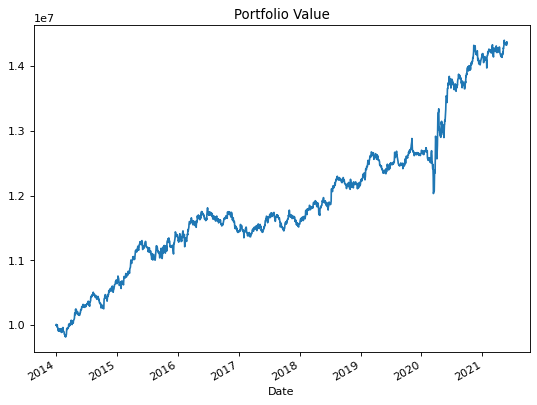

In [6]:
pv = pd.Series(results[0].pv)
dt = pd.to_datetime(pd.read_csv('../data/backtrader_csv/nasdaq1002/AAPL.csv')['Date'])
dt = dt[dt>='2014-01-02']
dt = dt[dt<='2021-05-28']

figure(figsize=(8, 6), dpi=80)
pd.Series(results[0].pv, index=dt).plot(title='Portfolio Value');

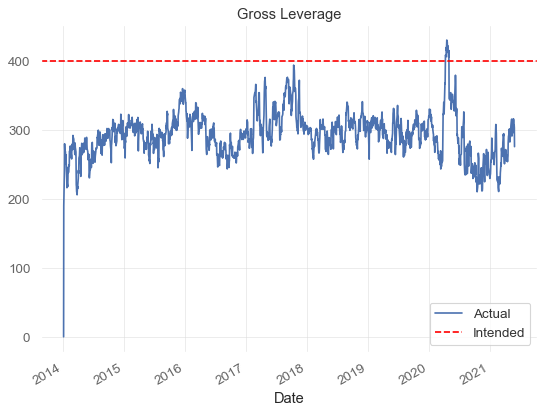

In [12]:
figure(figsize=(8, 6), dpi=80)
pd.Series(results[0].leverage_l, index=dt).plot(title='Gross Leverage');
plt.axhline(y=400, c='red', linestyle='dashed', label="horizontal")
labels = ["Actual", "Intended"]
plt.legend(labels = labels);

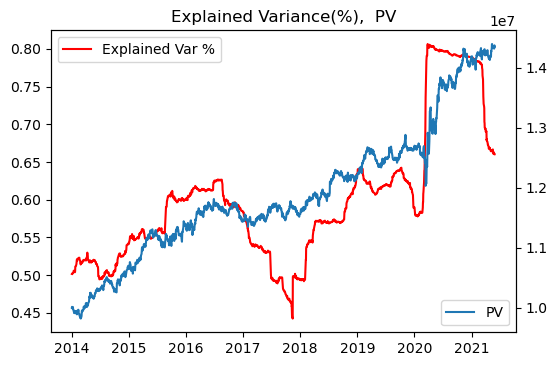

In [8]:
fig, ax1 = plt.subplots()
fig.set_dpi(100)
ax1.plot(pd.Series(results[0].explained_var, index=dt), color='red')
ax2 = ax1.twinx()
ax2.plot(pd.Series(results[0].pv, index=dt));
plt.title('Explained Variance(%),  PV')
ax1.legend(labels = ['Explained Var %'], loc='upper left');
ax2.legend(labels = ['PV'], loc='lower right');

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2021-05-28  2021-05-28
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          43.52%      164.04%
CAGR﹪                     5.0%        14.01%

Sharpe                     1.07        0.84
Smart Sharpe               1.01        0.8
Sortino                    1.69        1.17
Smart Sortino              1.59        1.1
Sortino/√2                 1.2         0.83
Smart Sortino/√2           1.13        0.78
Omega                      1.21        1.21

Max Drawdown               -6.59%      -33.72%
Longest DD Days            609         272
Volatility (ann.)          4.65%       17.33%
R^2                        0.01        0.01
Calmar                     0.76        0.42
Skew                       0.58        -0.72
Kurtosis                   6.52        1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-11-06,2020-03-13,2020-03-26,141,-6.594820,-6.353112
2,2016-06-29,2017-02-01,2018-02-28,609,-3.913766,-3.663116
3,2020-04-15,2020-05-15,2020-05-27,42,-3.329597,-3.295341
4,2020-03-27,2020-04-03,2020-04-07,11,-2.699931,-1.762505
5,2015-06-02,2015-08-19,2015-11-02,153,-2.668884,-2.644147


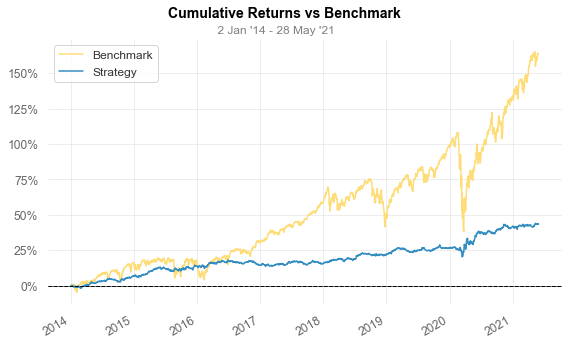

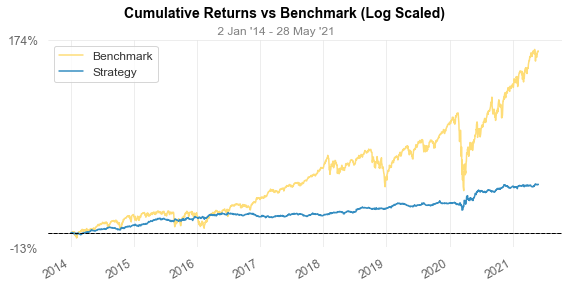

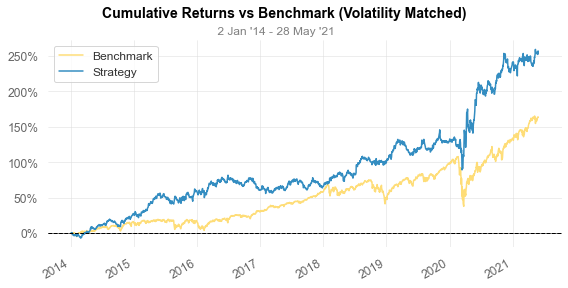

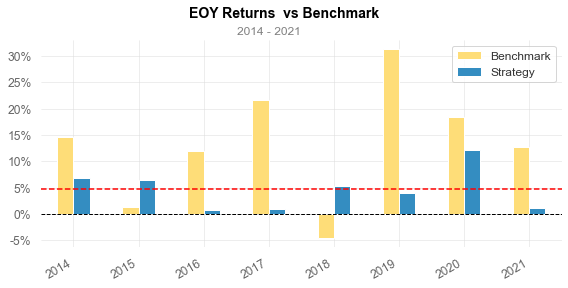

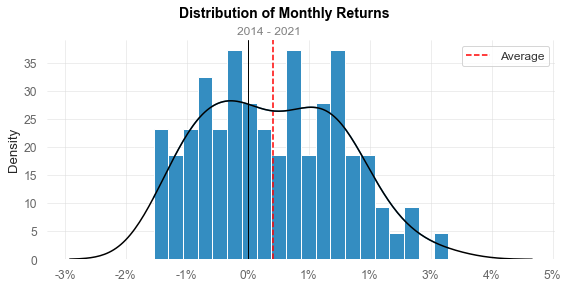

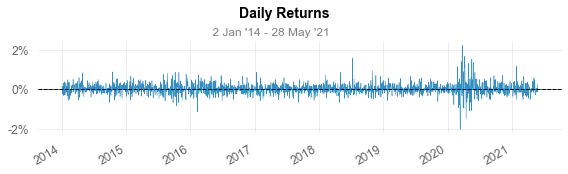

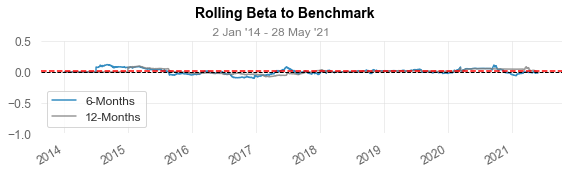

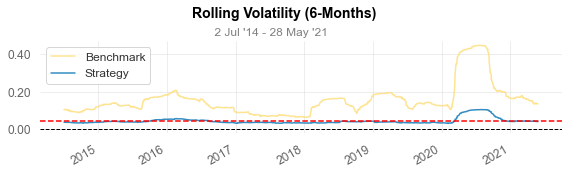

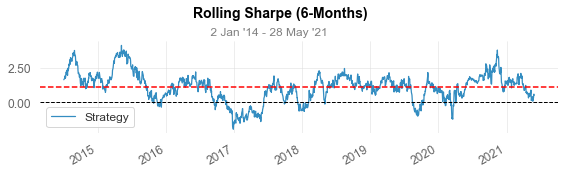

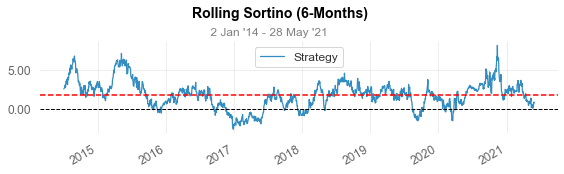

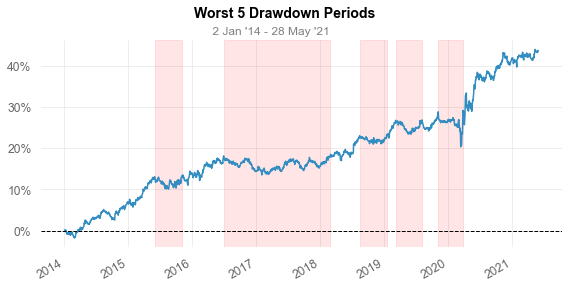

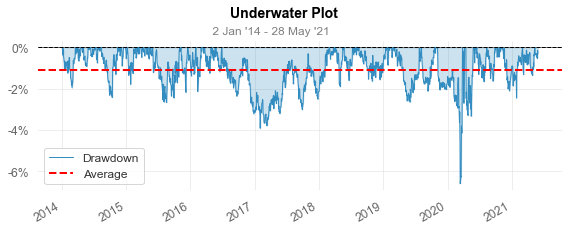

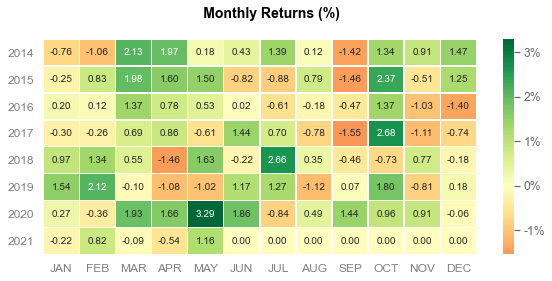

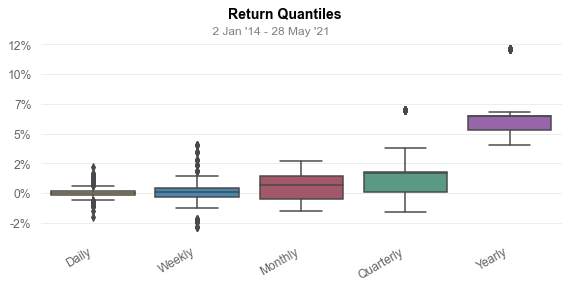

In [9]:
ret = pv.pct_change()
ret.index = dt
import quantstats as qs
pd.options.display.max_rows = 4000
qs.reports.full(ret, "SPY")

In [11]:
from IPython.display import HTML, display
qs.reports.html(ret, "SPY", output='../data/output/StatArb-1.07.html')